# Building Conductance-based Neuron Models

@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn) @chaoming0625


In this section, we try to understand how to build conductance-based biophysical neuron models.  


In [16]:
import numpy as np

import brainpy as bp
import brainpy.math as bm

There are basically two types of neuron models: **conductance-based models** and **simplified models**. In conductance-based models, a single neuron can be regarded as a electric circuit, where the membrane is a capacitor, ion channels are conductors, and ion gradients are batteries. The neuronal activity is captured by the current flows through those ion channels. Sometimes there is an external input to this neuron, which can also be included in the equivalent circuit (see the figure below which shows potassium channels, sodium channels and leaky channels).

<img src="../_static/conductance_model_diagram.png" width="400 px">



On the other hand, simplified models do not care about the physiological features of neurons but mainly focus on how to reproduce the exact spike timing. Therefore, they are more simplified and maybe not biologically explicable.

BrainPy provides a large volume of predefined neuron models including conductance-based and simplified models for ease of use. In this section, we will only talk about how to build conductance-based models by ion channels. Users please refer to [Customizing Your Neuron Models](customize_neuron_models.ipynb) for more information.

## ``master_type`` organizes structures between neurons and ion channels 

When defining a conductance neuron model, one additional thing need to be pay attention to is ``master_type``. 

``master_type`` determines what information will be passed into ``.reset_state()`` and ``update()`` function in a model.

In [17]:
class IK(bp.dyn.IonChannel):
  master_type = bp.dyn.CondNeuGroup

  def update(self, V, *args, **kwargs):
    pass

  def reset_state(self, V, *args, **kwargs):
    pass

For the above ``IK`` model, its ``master_type: bp.dyn.CondNeuGroup`` will give ``V`` variable into this node. Therefore, ``IK`` model can utilize ``V`` to update or reset its states. 

In [18]:
class ICa(bp.dyn.IonChannel):
  master_type = bp.dyn.Calcium

  def update(self, V, C, E, *args, **kwargs):
    pass

  def reset_state(self, V, C, E, *args, **kwargs):
    pass

For ``ICa`` class, its ``master_type (bp.dyn.Calcium)`` will deliver the concentration of Calcium ``C`` and the reversal potential of Calcium ion ``E`` into this node. Moreover, since the ``master_type`` of ``bp.dyn.Calcium`` is ``bp.dyn.CondNeuGroup``, it will inherit the passing of ``bp.dyn.CondNeuGroup`` and deliver ``V`` into ``ICa`` class too. 

In [19]:
class ICaNa(bp.dyn.IonChannel):
  master_type = bp.mixin.JointType[bp.dyn.Calcium, bp.dyn.Sodium]

  def update(self, V, Ca_info, Na_info, *args, **kwargs):
    pass

  def reset_state(self, V, Ca_info, Na_info, *args, **kwargs):
    pass

If an ion channel depends on more than two ion types, it can define ``master_type`` as a joint type by using ``brainpy.mixin.JointType``. For example, the above ``ICaNa`` class depends on ``bp.dyn.Calcium`` and ``bp.dyn.Sodium``, so the ``update()`` and ``reset_state()`` function depends on information of both subclasses and their parents. 

For an existing ion channel, users can check the ``master_type`` using:

In [20]:
bp.dyn.INa_Ba2002v2.master_type

brainpy._src.dyn.ions.sodium.Sodium

In [21]:
bp.dyn.INa_Ba2002.master_type

brainpy._src.dyn.neurons.hh.HHTypedNeuron

## Build a HH model by composing existing ion channels

Instead of building a conductance-based model from scratch, we can utilize ion channel models as building blocks to assemble a neuron model in a modular and convenient way. Now let's try to construct a **Hodgkin-Huxley (HH) model** (jump to [here](customize_neuron_models.ipynb) for the complete mathematical expression of the HH model).


The HH neuron models the current flows of potassium, sodium, and leaky channels. We can import the other channel models from ``brainpy.dyn.ions`` and ``brainpy.dyn.channels`` modules. Then we wrap these three channels into a single neuron model:

Here is an example by building a HH neuron model by composing existing ion channels. 

In [22]:
class HH(bp.dyn.CondNeuGroupLTC):
  def __init__(self, size):
    super().__init__(size)

    self.INa = bp.dyn.INa_HH1952(size)
    self.IK = bp.dyn.IK_HH1952(size)
    self.IL = bp.dyn.IL(size, E=-54.387, g_max=0.03)

Here the `HH` class should inherit the superclass **`brainpy.dyn.CondNeuGroup`**, which will automatically integrate the current flows by calling the `current()` function of each channel model to compute the neuronal activity when running a simulation.

Surprisingly, the model construction is finished! Users do not need to implement the update function of the neuron model as `brainpy.dyn.CondNeuGroupLTC` has its own way to update variables (like the membrane potential `V` and spiking sequence `spike`) implicitly.

Now let's run a simulation of this HH model to examine the changes of the inner variables.


In [23]:
hh = HH(1)

runner = bp.DSRunner(hh, monitors={'na-p': hh.INa.p, 'na-q': hh.INa.q, 'k-p': hh.IK.p, 'v': hh.V})

inputs = np.ones(1000) * 4.
_ = runner.run(inputs=inputs)


  0%|          | 0/1000 [00:00<?, ?it/s]

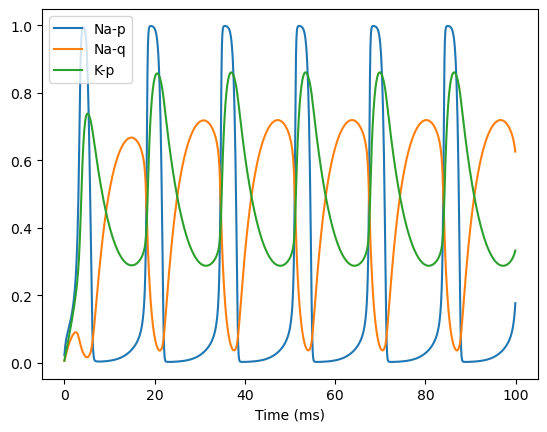

In [24]:
bp.visualize.line_plot(runner.mon.ts, runner.mon['na-p'], legend='Na-p')
bp.visualize.line_plot(runner.mon.ts, runner.mon['na-q'], legend='Na-q')
bp.visualize.line_plot(runner.mon.ts, runner.mon['k-p'], legend='K-p', show=True)

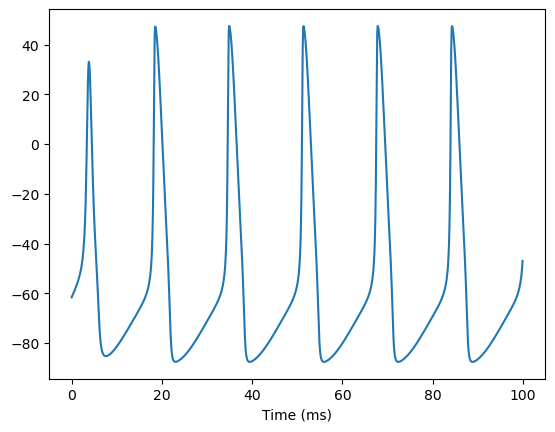

In [25]:
bp.visualize.line_plot(runner.mon.ts, runner.mon['v'], show=True)

## Customizing ion channels

To customize an ion channel that can be composed using the above interface, users should define a normal ``DynamicalSystem`` with the specification of ``master_type``.  Below we will show several examples. 

As we have known, ion channels are crucial for conductance-based neuron models. So how do we model an ion channel? Let's take a look at the potassium channel for instance.

<img src="../_static/potassium_channel_equivalent_circuit.png" width="500 px">

The diagram above shows how a potassium channel is changed to an electric circuit. By this, we have the differential equation:

$$
\begin{align}
c_\mathrm{M} \frac{\mathrm{d}V_\mathrm{M}}{\mathrm{d}t} &= \frac{E_\mathrm{K} - V_\mathrm{M}}{R_\mathrm{K}} \\
&= g_\mathrm{K}(E_\mathrm{K} - V_\mathrm{M}),
\end{align}
$$

in which $c_\mathrm{M}$ is the membrane capacitance, $\mathrm{d}V_\mathrm{M}$ is the membrane potential, $E_\mathrm{K}$ is the equilibrium potential of potassium ions, and $R_\mathrm{K}$ ($g_\mathrm{K}$) refers to the resistance (conductance) of the potassium channel. We define currents from inside to outside as the positive direction.

In the equation above, the conductance of potassium channels $g_\mathrm{K}$ does not remain a constant, but changes according to the membrane potential, by which the channel is categorized as **voltage-gated ion channels**. If we want to build an ion channel model, we should figure out how the conductance of the ion channel changes with membrane potential.

Fortunately, there has been a lot of work addressing this issue to formulate analytical expressions. For example, the conductance of one typical potassium channel can be written as:

$$
\begin{align}
g_\mathrm{K} &= \bar{g}_\mathrm{K} n^4, \\
\frac{\mathrm{d}n}{\mathrm{d}t} &= \phi [\alpha_n(V)(1-n) - \beta_n(V)n],
\end{align}
$$

in which $\bar{g}_\mathrm{K}$ refers to the maximal conductance and $n$, also named the gating variable, refers to the probability (proportion) of potassium channels to open. $\phi$ is a parameter showing the effects of temperature. In the differential equation of $n$, there are two parameters, $\alpha_n(V)$ and $\beta_n(V)$, that change with membrane potential:

$$
\begin{align}
\alpha_n(V) &= \frac{0.01(V+55)}{1 - \exp(-\frac{V+55}{10})}, \\
\beta_n(V) &= 0.125 \exp\left(-\frac{V+65}{80}\right).
\end{align}
$$

Now we have learned the mathematical expression of the potassium channel. Next, we try to build this channel in BrainPy.

In [26]:
class IK(bp.dyn.IonChannel):
  master_type = bp.dyn.HHTypedNeuron

  def __init__(self, size, E=-77., g_max=36., phi=1., method='exp_auto'):
    super().__init__(size)
    self.g_max = g_max
    self.E = E
    self.phi = phi

    self.integral = bp.odeint(self.dn, method=method)

  def dn(self, n, t, V):
    alpha_n = 0.01 * (V + 55) / (1 - bm.exp(-(V + 55) / 10))
    beta_n = 0.125 * bm.exp(-(V + 65) / 80)
    return self.phi * (alpha_n * (1. - n) - beta_n * n)

  def reset_state(self, V, batch_or_mode=None, **kwargs):
    self.n = bp.init.variable_(bm.zeros, self.num, batch_or_mode)

  def update(self, V):
    t = bp.share.load('t')
    dt = bp.share.load('dt')
    self.n.value = self.integral(self.n, t, V, dt=dt)

  def current(self, V):
    return self.g_max * self.n ** 4 * (self.E - V)

Note that besides the initialzation and update function, **another function named ``current()`` that computes the current flow through this channel must be implemented**. Then this potassium channel model can be used as a building block for assembling a conductance-based neuron model.

For a sodium ion channel,  

$$  
\begin{split}\begin{split}  
\begin{aligned}  
   I_{\mathrm{Na}} &= g_{\mathrm{max}} m^3 h \\  
   \frac {dm} {dt} &= \phi (\alpha_m (1-x)  - \beta_m) \\  
   &\alpha_m(V) = \frac {0.1(V-V_{sh}-5)}{1-\exp(\frac{-(V -V_{sh} -5)} {10})}  \\  
   &\beta_m(V) = 4.0 \exp(\frac{-(V -V_{sh}+ 20)} {18})  \\  
   \frac {dh} {dt} &= \phi (\alpha_h (1-x)  - \beta_h) \\  
   &\alpha_h(V) = 0.07 \exp(\frac{-(V-V_{sh}+20)}{20})  \\  
   &\beta_h(V) = \frac 1 {1 + \exp(\frac{-(V -V_{sh}-10)} {10})} \\  
\end{aligned}  
\end{split}\end{split}  
$$  

where $V_{sh}$ is the membrane shift (default -45 mV), and $\phi$  is the temperature-dependent factor (default 1.).

In [27]:
class INa(bp.dyn.IonChannel):
  master_type = bp.dyn.HHTypedNeuron

  def __init__(self, size, E=50., g_max=120., phi=1., method='exp_auto'):
    super(INa, self).__init__(size)
    self.g_max = g_max
    self.E = E
    self.phi = phi
    self.integral = bp.odeint(bp.JointEq(self.dm, self.dh), method=method)

  def dm(self, m, t, V):
    alpha_m = 0.11 * (V + 40) / (1 - bm.exp(-(V + 40) / 10))
    beta_m = 4 * bm.exp(-(V + 65) / 18)
    return self.phi * (alpha_m * (1. - m) - beta_m * m)

  def dh(self, h, t, V):
    alpha_h = 0.07 * bm.exp(-(V + 65) / 20)
    beta_h = 1. / (1 + bm.exp(-(V + 35) / 10))
    return self.phi * (alpha_h * (1. - h) - beta_h * h)

  def reset_state(self, V, batch_or_mode=None, **kwargs):
    self.m = bp.init.variable_(bm.zeros, self.num, batch_or_mode)
    self.h = bp.init.variable_(bm.zeros, self.num, batch_or_mode)

  def update(self, V):
    t = bp.share.load('t')
    dt = bp.share.load('dt')
    self.m.value, self.h.value = self.integral(self.m, self.h, t, V, dt=dt)

  def current(self, V):
    return self.g_max * self.m ** 3 * self.h * (self.E - V)

The leakage channel current.

In [28]:
class IL(bp.dyn.IonChannel):
  master_type = bp.dyn.HHTypedNeuron

  def __init__(self, size, E=-54.39, g_max=0.03):
    super(IL, self).__init__(size)
    self.g_max = g_max
    self.E = E

  def reset_state(self, *args, **kwargs):
    pass

  def update(self, V):
    pass

  def current(self, V):
    return self.g_max * (self.E - V)

We can compose a HH model by using three channels we defined in the above. 

In [29]:
class HH(bp.dyn.CondNeuGroup):
  def __init__(self, size):
    super().__init__(size, V_initializer=bp.init.Uniform(-80, -60.))
    self.IK = IK(size, E=-77., g_max=36.)
    self.INa = INa(size, E=50., g_max=120.)
    self.IL = IL(size, E=-54.39, g_max=0.03)

  0%|          | 0/2000 [00:00<?, ?it/s]

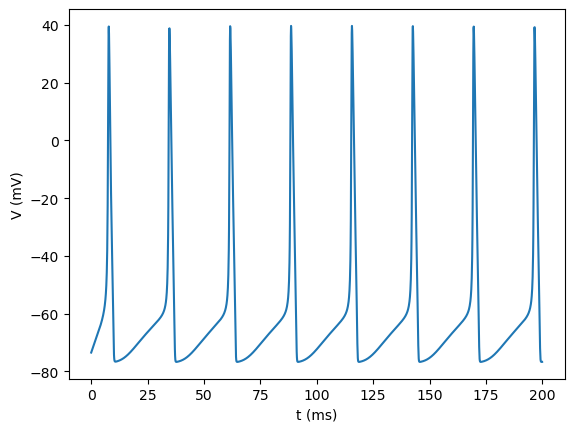

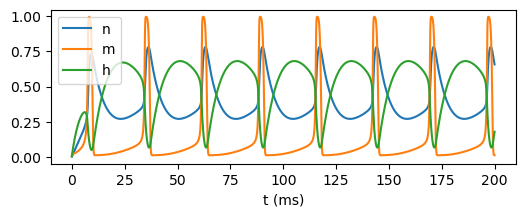

In [30]:
neu = HH(1)
neu.reset()

inputs = np.ones(int(200 / bm.dt)) * 1.698  # 200 ms
runner = bp.DSRunner(neu, monitors=['V', 'IK.n', 'INa.m', 'INa.h'])
runner.run(inputs=inputs)  # the running time is 200 ms

import matplotlib.pyplot as plt

plt.plot(runner.mon['ts'], runner.mon['V'])
plt.xlabel('t (ms)')
plt.ylabel('V (mV)')
plt.show()

plt.figure(figsize=(6, 2))
plt.plot(runner.mon['ts'], runner.mon['IK.n'], label='n')
plt.plot(runner.mon['ts'], runner.mon['INa.m'], label='m')
plt.plot(runner.mon['ts'], runner.mon['INa.h'], label='h')
plt.xlabel('t (ms)')
plt.legend()

plt.show()

## Building a complex thalamus neuron model

Li, et. al [1] proposed a point model of thalamic cells, all single cell models in the thalamic network contained one single compartment and multiple ionic currents described by the Hodgkin-Huxley formulism. The current balance equation was given by:  

$$  
C_m \frac{d V}{d t}=-g_L\left(V-E_L\right)-g_{K L}\left(V-E_{K L}\right)-\sum I^{i n t}-10^{-3} \sum \frac{I^{s n}}{A}+10^{-3} \frac{I_{a p p}}{A}  
$$  


where $Cm = 1μF/cm^2$ is the membrane capacitance for all four types of neurons, $g_L$ is the leakage conductance (nominal value: $gL = 0.01 mS/cm^2$ for all four types of cells) and $g_{KL}$ is the potassium leak conductance modulated by both ACh and NE. $E_L$ is the leakage reversal potential ($E_L$ = −70 mV for both HTC cells), and $E_{KL}$ is the reversal potential for the potassium leak current ($E_{KL}$ = −90 mV for all neurons). $I_{int}$ and $I_{syn}$ are the intrinsic ionic currents (in $μA/cm^2$) and synaptic currents (in $nA$) respectively and $I_{app}$ is the externally applied current injection (in $nA$). The following total membrane area (A) was used to normalize the synaptic and externally applied currents in Eq: HTC cells: 2.9×10−4 $cm^2$.


HTC cells contained the following six active ionic currents:  

- a spike generating fast sodium current (INa),  ``bp.dyn.INa_Ba2002``  
- a delayed rectifier potassium current (IDR), ``bp.dyn.IKDR_Ba2002``  
- a hyperpolarization-activated cation current (IH), ``bp.dyn.Ih_HM1992``  
- a high-threshold L-type Ca2+ current (ICa/L), ``bp.dyn.ICaL_IS2008``  
- a Ca2+- dependent potassium current (IAHP), ``bp.dyn.IAHP_De1994``  
- a Ca2+- activated nonselective cation current (ICAN). ``bp.dyn.ICaN_IS2008``  

In addition, both TC cells included  
- a regular low-threshold T-type Ca2+ current (ICa/T), ``bp.dyn.ICaT_HM1992``  
- and a high-threshold T-type Ca2+ current (ICa/HT); ``bp.dyn.ICaHT_HM1992``  

To obtain the high-threshold T-type current ICa/HT, both the activation and inactivation of the ICa/T current was shifted by 28 mV, similar to a previous TC modeling study. 


[1] Li G, Henriquez CS, Fröhlich F (2017) Unified thalamic model generates multiple distinct oscillations with state-dependent entrainment by stimulation. PLoS Comput Biol 13(10): e1005797. https://doi.org/10.1371/journal.pcbi.1005797

In BrainPy, this model can be modeled as:

In [31]:
class HTC(bp.dyn.CondNeuGroupLTC):
  def __init__(self, size, gKL=0.01, V_initializer=bp.init.OneInit(-65.)):
    super().__init__(size, A=2.9e-4, V_initializer=V_initializer, V_th=20.)
    self.IL = bp.dyn.IL(size, g_max=0.01, E=-70.)
    self.INa = bp.dyn.INa_Ba2002(size, V_sh=-30)
    self.Ih = bp.dyn.Ih_HM1992(size, g_max=0.01, E=-43)

    self.Ca = bp.dyn.CalciumDetailed(size, C_rest=5e-5, tau=10., d=0.5)
    self.Ca.add_elem(bp.dyn.ICaL_IS2008(size, g_max=0.5))
    self.Ca.add_elem(bp.dyn.ICaN_IS2008(size, g_max=0.5))
    self.Ca.add_elem(bp.dyn.ICaT_HM1992(size, g_max=2.1))
    self.Ca.add_elem(bp.dyn.ICaHT_HM1992(size, g_max=3.0))

    self.K = bp.dyn.PotassiumFixed(size, E=-90.)
    self.K.add_elem(bp.dyn.IKDR_Ba2002v2(size, V_sh=-30., phi=0.25))
    self.K.add_elem(bp.dyn.IK_Leak(size, g_max=gKL))

    self.KCa = bp.dyn.MixIons(self.K, self.Ca)
    self.KCa.add_elem(bp.dyn.IAHP_De1994v2(size))

  0%|          | 0/20000 [00:00<?, ?it/s]

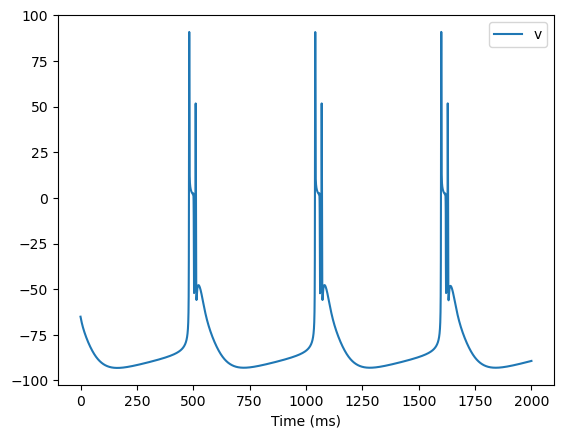

In [32]:
htc = HTC(1)
runner = bp.DSRunner(htc, monitors={'v': htc.V})
I = -30 / 1e3 / 2.9e-4 * 1e-3  # input current = -30pA
inputs = np.ones(20000) * I
runner.run(inputs=inputs)
bp.visualize.line_plot(runner.mon.ts, runner.mon['v'], legend='v', show=True)